In [10]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import os
from pathlib import Path
import sys
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
import datetime as dt
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
tri_path = os.environ.get('TRIPATH_DIR')
if tri_path and tri_path not in sys.path:
    sys.path.append(tri_path)
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
from monai.transforms import Resize

In [2]:
data_dir = Path(os.environ['DATA_DIR'])
patch_dir = data_dir / "patches"
paths = list(patch_dir.rglob("*.npy"))

In [3]:
len(paths)

1219

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
DEVICE

device(type='cuda')

In [5]:
def prepare_data(patch_dir):
    paths = list(patch_dir.rglob("*.npy"))
    patches = [np.load(path) for path in paths]
    patches = torch.stack([torch.from_numpy(patch) for patch in patches])
    patches = patches.float()
    patches = 1 - patches
    patches -= patches.amin(dim=(1, 2, 3), ).unsqueeze(1).unsqueeze(2).unsqueeze(3)
    patches /= patches.amax(dim=(1, 2, 3), ).unsqueeze(1).unsqueeze(2).unsqueeze(3)
    patches = patches.unsqueeze(1)
    targets = [path.parent.name for path in paths]
    return patches, targets

In [6]:
class PatchDataset(Dataset):
    def __init__(self, patches, targets, shape=(16, 16, 16)):
        self.patches = patches
        self.targets = targets
        self.resizer = Resize(spatial_size=shape)

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        patch = self.patches[idx]
        patch = self.resizer(patch)
        return patch, self.targets[idx]

In [7]:

patches, targets = prepare_data(patch_dir)
le = LabelEncoder()
targets = le.fit_transform(targets)

In [8]:
targets

array([3, 3, 3, ..., 4, 4, 4])

In [9]:
dataset = PatchDataset(patches, targets)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

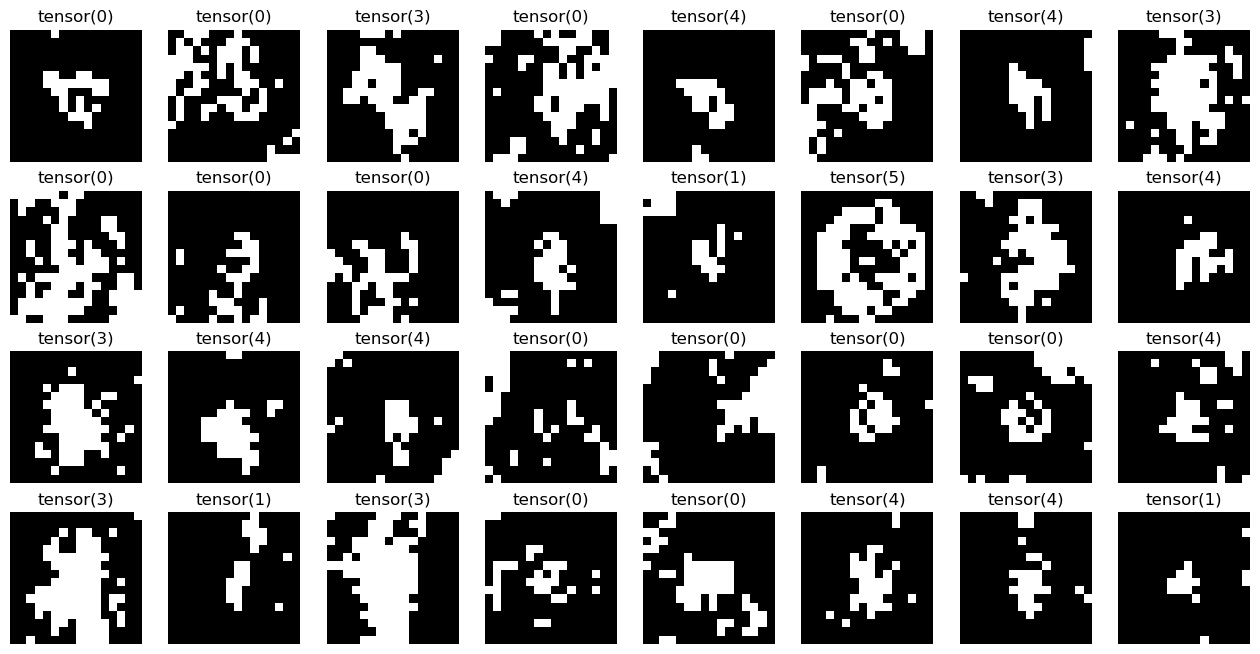

In [11]:
fig, axs = plt.subplots(4, 8, figsize=(16, 8))
axi = axs.flat
for batch in loader:
    for image, target in zip(*batch):
        plt.sca(next(axi))
        plt.imshow(image[0].max(dim=0)[0] >0.5, cmap="gray")
        plt.title(target)
        plt.axis("off")
    break

In [12]:
images = batch[0]
images.shape

torch.Size([32, 1, 16, 16, 16])

In [65]:
class VAE(nn.Module):
    def __init__(self,latent_size=32):
        super(VAE,self).__init__()
        self.latent_size = latent_size

        # For encode # 1,16,16,16
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, stride=2) # 16,7,7,7
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, stride=2) # 32,3,3,3
        self.linear1 = nn.Linear(3*3*3*32, 256) # 256
        self.mu = nn.Linear(256, self.latent_size) # latent_size
        self.logvar = nn.Linear(256, self.latent_size) # latent_size

        # For decoder
        self.linear2 = nn.Linear(self.latent_size, 256) # 256
        self.linear3 = nn.Linear(256,3*3*3*32) 
        self.conv3 = nn.ConvTranspose3d(32, 16, kernel_size=3,stride=2)
        self.conv4 = nn.ConvTranspose3d(16, 1, kernel_size=3, stride=2, output_padding=1)

    def encoder(self,x):
        t = F.relu(self.conv1(x))
        t = F.relu(self.conv2(t))
        t = t.reshape((x.shape[0], -1))

        t = F.relu(self.linear1(t))
        mu = self.mu(t)
        logvar = self.logvar(t)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std).to(DEVICE)
        return eps*std + mu

    def unFlatten(self, x):
        return x.reshape((x.shape[0], 32, 3, 3, 3))

    def decoder(self, z):
        t = F.relu(self.linear2(z))
        t = F.relu(self.linear3(t))
        t = self.unFlatten(t)
        t = F.relu(self.conv3(t))
        t = F.relu(self.conv4(t))
        return t


    def forward(self, x, y):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu,logvar)
        pred = self.decoder(z)
        return pred, mu, logvar


In [66]:
for batch in loader:
    break
model = VAE().to(DEVICE)
model(batch[0].to(DEVICE), batch[1].to(DEVICE))[0].shape

torch.Size([32, 1, 16, 16, 16])

In [53]:
vae = VAE()
print(image.shape)
out = vae.conv1(image)
print(out.shape)
out = vae.conv2(out)
print(out.shape)
out = out.view(-1)
print(out.shape)
out = vae.linear1(out.view(-1))
print(out.shape)
out = vae.mu(out)
print(out.shape)
out = vae.linear2(out)
print(out.shape)
out = vae.linear3(out)
print(out.shape)
out = out.view(32, 3, 3, 3)
print(out.shape)
out = vae.conv3(out)
print(out.shape)
out = vae.conv4(out)
print(out.shape)



torch.Size([1, 16, 16, 16])
torch.Size([16, 7, 7, 7])
torch.Size([32, 3, 3, 3])
torch.Size([864])
torch.Size([256])
torch.Size([32])
torch.Size([256])
torch.Size([864])
torch.Size([32, 3, 3, 3])
torch.Size([16, 7, 7, 7])
torch.Size([1, 15, 15, 15])


In [48]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [70]:
N_EPOCHS = 100
for epoch in tqdm(range(N_EPOCHS)):
    train(epoch, model, loader, optimizer)

  1%|          | 1/100 [00:01<02:32,  1.54s/it]

10671.716831723621 0.000950987955022044 10671.715855161121


  2%|▏         | 2/100 [00:03<02:33,  1.57s/it]

10671.234383011177 0.0009509879481937458 10671.233406448677


  3%|▎         | 3/100 [00:04<02:31,  1.56s/it]

10675.807176672894 0.000950987951202017 10675.806200260604


  4%|▍         | 4/100 [00:06<02:29,  1.56s/it]

10673.38629395733 0.0009509879573140602 10673.38531739483


  5%|▌         | 5/100 [00:07<02:28,  1.56s/it]

10669.715188831458 0.0009509879520615231 10669.714212268958


  6%|▌         | 6/100 [00:09<02:26,  1.56s/it]

10679.784645938013 0.0009509879558815501 10679.783669375513


  7%|▋         | 7/100 [00:10<02:25,  1.56s/it]

10670.505103420292 0.0009509879580780656 10670.504126857792


  8%|▊         | 8/100 [00:12<02:25,  1.59s/it]

10670.306420317627 0.0009509879580780656 10670.305443755127


  9%|▉         | 9/100 [00:14<02:24,  1.59s/it]

10676.741859792783 0.0009509879505335123 10676.740883380493


 10%|█         | 10/100 [00:15<02:23,  1.60s/it]

10679.108220889786 0.0009509879542580386 10679.107244327286


 11%|█         | 11/100 [00:17<02:20,  1.58s/it]

10677.425001762458 0.0009509879520615231 10677.424025199958


 12%|█▏        | 12/100 [00:18<02:17,  1.56s/it]

10674.011225461763 0.0009509879520137728 10674.010248899263


 13%|█▎        | 13/100 [00:20<02:14,  1.55s/it]

10671.886707534351 0.0009509879566455554 10671.885730971851


 14%|█▍        | 14/100 [00:21<02:14,  1.56s/it]

10683.85063490582 0.0009509879504380116 10683.849658493531


 15%|█▌        | 15/100 [00:23<02:14,  1.59s/it]

10680.515370795334 0.0009509879543535393 10680.514394383043


 16%|█▌        | 16/100 [00:25<02:13,  1.59s/it]

10671.691049952895 0.0009509879528255285 10671.690073390395


 17%|█▋        | 17/100 [00:26<02:13,  1.60s/it]

10679.097060568905 0.0009509879542580386 10679.096084156616


 18%|█▊        | 18/100 [00:28<02:10,  1.59s/it]

10674.571564747135 0.0009509879558337997 10674.570588184635


 19%|█▉        | 19/100 [00:29<02:07,  1.58s/it]

10669.44130450805 0.0009509879573140602 10669.44032794555


 20%|██        | 20/100 [00:31<02:05,  1.56s/it]

10669.009359558457 0.0009509879542580386 10669.008382995957


 21%|██        | 21/100 [00:33<02:03,  1.57s/it]

10671.606797003178 0.0009509879527300278 10671.605820440678


 22%|██▏       | 22/100 [00:34<02:00,  1.55s/it]

10674.362723071228 0.0009509879519660224 10674.361746508728


 23%|██▎       | 23/100 [00:36<02:00,  1.56s/it]

10674.231270368418 0.0009509879543535393 10674.230293805918


 24%|██▍       | 24/100 [00:37<01:58,  1.56s/it]

10679.296969581961 0.0009509879473819901 10679.295993019461


 25%|██▌       | 25/100 [00:39<01:56,  1.56s/it]

10676.910203866435 0.0009509879543535393 10676.909227303935


 26%|██▌       | 26/100 [00:40<01:54,  1.55s/it]

10676.517515387468 0.0009509879466179847 10676.516538975178


 27%|██▋       | 27/100 [00:42<01:51,  1.53s/it]

10676.453066768756 0.0009509879520615231 10676.452090206256


 28%|██▊       | 28/100 [00:43<01:50,  1.54s/it]

10674.996103163134 0.0009509879505335123 10674.995126600634


 29%|██▉       | 29/100 [00:45<01:49,  1.55s/it]

10674.917843375077 0.0009509879527777781 10674.916866812577


 30%|███       | 30/100 [00:46<01:49,  1.56s/it]

10678.949705979783 0.0009509879474297404 10678.948729417283


 31%|███       | 31/100 [00:48<01:48,  1.57s/it]

10674.446363866868 0.000950987951202017 10674.445387304368


 32%|███▏      | 32/100 [00:50<01:45,  1.55s/it]

10678.749598039185 0.0009509879588898213 10678.748621476685


 33%|███▎      | 33/100 [00:51<01:44,  1.56s/it]

10681.53857056365 0.0009509879527300278 10681.53759415136


 34%|███▍      | 34/100 [00:53<01:43,  1.56s/it]

10669.584182050798 0.0009509879551175447 10669.583205488298


 35%|███▌      | 35/100 [00:54<01:41,  1.57s/it]

10676.911403690428 0.0009509879504380116 10676.910427278139


 36%|███▌      | 36/100 [00:56<01:40,  1.56s/it]

10672.854244842405 0.0009509879496740062 10672.853268279905


 37%|███▋      | 37/100 [00:57<01:39,  1.57s/it]

10677.766916852392 0.0009509879489577512 10677.765940440102


 38%|███▊      | 38/100 [00:59<01:37,  1.57s/it]

10675.760615410622 0.0009509879497695069 10675.759638848122


 39%|███▉      | 39/100 [01:01<01:35,  1.57s/it]

10677.26475748965 0.0009509879612295878 10677.26378092715


 40%|████      | 40/100 [01:02<01:34,  1.57s/it]

10675.38786394778 0.0009509879497217566 10675.38688738528


 41%|████      | 41/100 [01:04<01:32,  1.57s/it]

10675.516380904639 0.0009509879589375716 10675.515404492347


 42%|████▏     | 42/100 [01:05<01:30,  1.57s/it]

10674.149525417863 0.0009509879443259685 10674.148548855363


 43%|████▎     | 43/100 [01:07<01:29,  1.57s/it]

10666.664609763542 0.0009509879496740062 10666.663633201042


 44%|████▍     | 44/100 [01:08<01:27,  1.57s/it]

10674.344570544825 0.0009509879512497674 10674.343593982325


 45%|████▌     | 45/100 [01:10<01:27,  1.58s/it]

10675.24528216768 0.0009509879558815501 10675.24430575539


 46%|████▌     | 46/100 [01:12<01:25,  1.59s/it]

10676.95203633109 0.0009509879534940332 10676.951059918798


 47%|████▋     | 47/100 [01:13<01:23,  1.57s/it]

10673.915339681924 0.000950987951202017 10673.914363119424


 48%|████▊     | 48/100 [01:15<01:21,  1.56s/it]

10676.44693150884 0.0009509879574095608 10676.44595494634


 49%|████▉     | 49/100 [01:16<01:19,  1.55s/it]

10677.674595045008 0.0009509879574095608 10677.673618632716


 50%|█████     | 50/100 [01:18<01:17,  1.54s/it]

10671.770533648547 0.0009509879551175447 10671.769557086047


 51%|█████     | 51/100 [01:19<01:15,  1.54s/it]

10678.510210796103 0.0009509879520137728 10678.509234233603


 52%|█████▏    | 52/100 [01:21<01:13,  1.53s/it]

10669.617856633575 0.0009509879519660224 10669.616880071075


 53%|█████▎    | 53/100 [01:22<01:11,  1.52s/it]

10673.866060627788 0.0009509879482414961 10673.865084065288


 54%|█████▍    | 54/100 [01:24<01:08,  1.50s/it]

10677.940700815778 0.00095098794594948 10677.939724253278


 55%|█████▌    | 55/100 [01:25<01:06,  1.48s/it]

10674.177306377858 0.000950987946665735 10674.176329815358


 56%|█████▌    | 56/100 [01:27<01:06,  1.52s/it]

10682.197864210146 0.0009509879596538267 10682.196887647646


 57%|█████▋    | 57/100 [01:28<01:05,  1.52s/it]

10671.920442000679 0.0009509879505335123 10671.919465438179


 58%|█████▊    | 58/100 [01:30<01:04,  1.53s/it]

10680.497838734602 0.0009509879496740062 10680.496862322312


 59%|█████▉    | 59/100 [01:31<01:01,  1.50s/it]

10675.175484986654 0.0009509879603700818 10675.174508574362


 60%|██████    | 60/100 [01:33<00:58,  1.46s/it]

10676.425160533978 0.0009509879504380116 10676.424184121686


 61%|██████    | 61/100 [01:34<00:58,  1.50s/it]

10675.910715580378 0.0009509879512975177 10675.909739017878


 62%|██████▏   | 62/100 [01:36<00:56,  1.48s/it]

10678.264517104264 0.0009509879420339523 10678.263540691973


 63%|██████▎   | 63/100 [01:37<00:53,  1.46s/it]

10669.221165470064 0.000950987951202017 10669.220188907564


 64%|██████▍   | 64/100 [01:39<00:52,  1.45s/it]

10667.463325431641 0.0009509879589375716 10667.462348869141


 65%|██████▌   | 65/100 [01:40<00:50,  1.44s/it]

10674.184712711174 0.000950987959701577 10674.183736148674


 66%|██████▌   | 66/100 [01:41<00:49,  1.47s/it]

10675.352800577366 0.0009509879550697943 10675.351824165075


 67%|██████▋   | 67/100 [01:43<00:48,  1.46s/it]

10675.968090630047 0.000950987951202017 10675.967114067547


 68%|██████▊   | 68/100 [01:44<00:45,  1.43s/it]

10668.36872955147 0.0009509879558815501 10668.36775298897


 69%|██████▉   | 69/100 [01:46<00:44,  1.42s/it]

10676.343392551287 0.0009509879535417835 10676.342416138998


 70%|███████   | 70/100 [01:47<00:42,  1.43s/it]

10677.908862645163 0.0009509879489100008 10677.907886232872


 71%|███████   | 71/100 [01:49<00:42,  1.47s/it]

10679.564004749427 0.0009509879558337997 10679.563028337136


 72%|███████▏  | 72/100 [01:50<00:41,  1.49s/it]

10673.88792403161 0.0009509879642856094 10673.88694746911


 73%|███████▎  | 73/100 [01:52<00:40,  1.49s/it]

10670.388723547092 0.000950987959701577 10670.387746984592


 74%|███████▍  | 74/100 [01:53<00:38,  1.49s/it]

10676.712375406167 0.0009509879505335123 10676.711398843667


 75%|███████▌  | 75/100 [01:55<00:37,  1.50s/it]

10671.66655297471 0.000950987951202017 10671.66557641221


 76%|███████▌  | 76/100 [01:56<00:35,  1.49s/it]

10672.347263902597 0.0009509879528255285 10672.346287340097


 77%|███████▋  | 77/100 [01:58<00:34,  1.51s/it]

10671.4426291562 0.000950987950485762 10671.4416525937


 78%|███████▊  | 78/100 [01:59<00:32,  1.49s/it]

10680.201352627186 0.0009509879558815501 10680.200376064686


 79%|███████▉  | 79/100 [02:01<00:31,  1.51s/it]

10678.355847778821 0.0009509879581258159 10678.354871216321


 80%|████████  | 80/100 [02:02<00:30,  1.51s/it]

10673.769742344519 0.0009509879557860494 10673.768765782019


 81%|████████  | 81/100 [02:04<00:28,  1.49s/it]

10677.09114326308 0.0009509879520137728 10677.09016670058


 82%|████████▏ | 82/100 [02:05<00:26,  1.50s/it]

10680.042046663504 0.0009509879519660224 10680.041070251214


 83%|████████▎ | 83/100 [02:07<00:25,  1.50s/it]

10676.47551939466 0.0009509879542580386 10676.474542982369


 84%|████████▍ | 84/100 [02:08<00:23,  1.48s/it]

10674.535461275571 0.0009509879482414961 10674.534484713071


 85%|████████▌ | 85/100 [02:10<00:22,  1.50s/it]

10671.240748692577 0.0009509879551175447 10671.239772130077


 86%|████████▌ | 86/100 [02:11<00:20,  1.50s/it]

10671.174915241745 0.0009509879596060764 10671.173938679245


 87%|████████▋ | 87/100 [02:13<00:19,  1.50s/it]

10675.351963759838 0.0009509879490055015 10675.350987197338


 88%|████████▊ | 88/100 [02:14<00:17,  1.50s/it]

10678.139811965655 0.000950987963521604 10678.138835403155


 89%|████████▉ | 89/100 [02:16<00:16,  1.50s/it]

10678.58010651461 0.0009509879574095608 10678.57912995211


 90%|█████████ | 90/100 [02:17<00:14,  1.48s/it]

10678.42821554633 0.0009509879534940332 10678.42723898383


 91%|█████████ | 91/100 [02:19<00:13,  1.46s/it]

10675.285358882713 0.000950987950485762 10675.284382320213


 92%|█████████▏| 92/100 [02:20<00:11,  1.47s/it]

10675.53455921702 0.0009509879565500548 10675.53358280473


 93%|█████████▎| 93/100 [02:22<00:10,  1.50s/it]

10674.952132815704 0.0009509879557860494 10674.951156253204


 94%|█████████▍| 94/100 [02:23<00:09,  1.50s/it]

10666.613187419087 0.0009509879474774908 10666.612210856587


 95%|█████████▌| 95/100 [02:25<00:07,  1.50s/it]

10673.936826460278 0.0009509879589375716 10673.935849897778


 96%|█████████▌| 96/100 [02:26<00:06,  1.52s/it]

10671.019554382274 0.000950987958842071 10671.018577819774


 97%|█████████▋| 97/100 [02:28<00:04,  1.53s/it]

10677.63794776472 0.0009509879581735662 10677.63697120222


 98%|█████████▊| 98/100 [02:29<00:03,  1.53s/it]

10673.243593762018 0.0009509879558815501 10673.242617199518


 99%|█████████▉| 99/100 [02:31<00:01,  1.50s/it]

10675.586866496136 0.0009509879490055015 10675.585889933636


100%|██████████| 100/100 [02:32<00:00,  1.53s/it]

10680.797392522047 0.0009509879520615231 10680.796415959547


In [68]:

def loss_function(x, pred, mu, logvar):
    recon_loss = F.mse_loss(pred, x, reduction='sum')
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss, kld


def train(epoch, model, loader, optim):
    reconstruction_loss = 0
    kld_loss = 0
    total_loss = 0
    for i,(x,y) in enumerate(loader):
        # try:
            optim.zero_grad()
            pred, mu, logvar = model(x.to(DEVICE),y.to(DEVICE))

            recon_loss, kld = loss_function(x.to(DEVICE),pred, mu, logvar)
            loss = recon_loss + kld
            loss.backward()
            optim.step()

            total_loss += loss.cpu().data.numpy()*x.shape[0]
            reconstruction_loss += recon_loss.cpu().data.numpy()*x.shape[0]
            kld_loss += kld.cpu().data.numpy()*x.shape[0]
            # if i == 0:
            #     print("Gradients")
            #     for name,param in model.named_parameters():
            #         if "bias" in name:
            #             print(name,param.grad[0],end=" ")
            #         else:
            #             print(name,param.grad[0,0],end=" ")
            #         print()
        # except Exception as e:
        #     continue

    reconstruction_loss /= len(loader.dataset)
    kld_loss /= len(loader.dataset)
    total_loss /= len(loader.dataset)
    print(total_loss, kld_loss,reconstruction_loss)
    return total_loss, kld_loss,reconstruction_loss


In [33]:
train(1, model, loader, optimizer)

/home/etienne.doumazane/programs/miniconda3/envs/cryoet/lib/python3.10/site-packages/torch/_tensor.py:1512: UserWarning: Using a target size (torch.Size([32, 1, 16, 16, 16])) that is different to the input size (torch.Size([32, 1, 17, 17, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ret = func(*args, **kwargs)


RuntimeError: The size of tensor a (17) must match the size of tensor b (16) at non-singleton dimension 4

In [ ]:
class VAE3D(nn.Module):
    def __init__(self, in_channels=1, latent_dim=128):
        super(VAE3D, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder_conv1 = nn.Conv3d(in_channels, 32, kernel_size=3, stride=2, padding=1)
        self.encoder_conv2 = nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1)
        self.encoder_conv3 = nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1)

        # Compute the flattened size after convolution
        self.fc_input_dim = 128 * 4 * 4 * 4

        # Fully connected layers for the mean and log variance
        self.fc_mu = nn.Linear(self.fc_input_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.fc_input_dim, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, self.fc_input_dim)
        self.decoder_conv1 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder_conv2 = nn.ConvTranspose3d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder_conv3 = nn.ConvTranspose3d(32, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1)

    def encode(self, x):
        h = F.relu(self.encoder_conv1(x))
        h = F.relu(self.encoder_conv2(h))
        h = F.relu(self.encoder_conv3(h))
        h = h.view(-1, self.fc_input_dim)  # Flatten
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc_decode(z)).view(-1, 128, 4, 4, 4)
        h = F.relu(self.decoder_conv1(h))
        h = F.relu(self.decoder_conv2(h))
        return torch.sigmoid(self.decoder_conv3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function for VAE
def vae_loss(recon_x, x, mu, logvar):
    bce_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce_loss + kld_loss

# Example usage
model = VAE3D().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# Dummy 3D data: batch size of 8, single channel, 3D patch size 32x32x32
# data = torch.randn(8, 1, 32, 32, 32).to(device)
# data = torch.sigmoid(data)

data_dir = Path(os.environ['DATA_DIR'])
patch_dir = data_dir / "patches"
paths = list(patch_dir.rglob("*.npy"))
dataset = PatchDataset(paths)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Training step

for epoch in range(10):
    for batch in tqdm(dataloader):
        model.train()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(batch[0].to(device))
        loss = vae_loss(recon_batch, batch[0], mu, logvar)
        loss.backward()
        optimizer.step()


    print(f"Training loss: {loss.item()}")

TypeError: PatchDataset.__init__() missing 1 required positional argument: 'targets'